In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
#reading freesurfer results
out_dir = Path("/output")
fig_dir = out_dir / "figs"
fsdata_file = out_dir / 'freesurfer_out_preped.csv'
GROUPS  = ['PD','ET','NC']
tab_data = pd.read_csv(fsdata_file, sep=',', header=0, index_col=0);

#excluding list
tab_data=tab_data.drop(index='sub_0064'); # super large head normal control, NC

# distribution of large brain parts ratio
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
tab_data=tab_data.drop(columns=drop_col_list);
for x in GROUPS:
    print(x , len(tab_data[tab_data["diagnosis"]==x]))

210205-12:31:31,606 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
PD 42
ET 38
NC 32


In [2]:
# prepare target data
g_var_list  = ['age', 'sex', 'diagnosis', 'eTIV'];
s_var_list  = ['BrainSegVol','CSF','CerebralWhiteMatterVol','CortexVol', 'Brain_Stem', 'SubCortGrayVol', 'TotalGrayVol',
               'CC_Anterior','CC_Mid_Anterior','CC_Central','CC_Mid_Posterior','CC_Posterior',
               '3rd_Ventricle','4th_Ventricle','SupraTentorialVol'];
lr_var_list = ['Cerebellum_Cortex','Cerebellum_White_Matter',
               'Accumbens_area', 'Amygdala','Hippocampus',
               'Caudate', 'Pallidum', 'Putamen', 'Thalamus_Proper', 
               'Inf_Lat_Vent','Lateral_Ventricle'];
def sum_lr(data, var_list):
    item_left   = [ "Left_"+x  for x in var_list];
    item_right  = [ "Right_"+x for x in var_list];
    for x in var_list:
        data[x] = data['Left_'+x]+ data['Right_'+x];
    return data, var_list+item_left+item_right
curr_data, curr_lr_list = sum_lr(tab_data, lr_var_list);

In [3]:
def ctr_age(data, y_var):
    from sklearn import linear_model
    import numpy as np
    dat = data.copy(); n_all = dat.shape[0];
    nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0];
    x_nc = np.hstack((np.ones((n_nc,1)),  np.array(nc_data['age']).reshape(-1, 1))); 
    x_all= np.hstack((np.ones((n_all,1)), np.array(dat['age']).reshape(-1, 1)));
    reg_list = []; new_col=[];
    for x in y_var:
        reg = linear_model.LinearRegression()
        y_nc= np.array(nc_data[x]);
        reg.fit(x_nc, y_nc);
        tmp_col = x+"_xa"
        dat[tmp_col] = dat[x]-np.matmul(x_all, reg.coef_)
        new_col.append(tmp_col); 
    return dat, new_col, reg_list

def ctr_conf(data, ctr_var, y_var, method_name):
    from sklearn import linear_model
    import numpy as np
    dat = data.copy(); n_all = dat.shape[0];
    if method_name == 'dpa': # direct proportion adjustment
        new_col=[];
        for x in y_var:
            r_name = x+'_dpa'; new_col.append(r_name);
            dat[r_name] = dat[x]/dat[ctr_var];
        dat_, col_, reg_list_ = ctr_age(dat, new_col);
        return dat_, new_col+col_
    if method_name == 'ppa': # power_corrected_portion
        reg_list = []; new_col=[];
        log_ctr  = np.log10(np.array(dat[ctr_var]));
        x_mat    = np.hstack((np.ones((n_all, 1)), np.reshape(log_ctr, [n_all, 1])))
        for x in y_var:
            reg = linear_model.LinearRegression()
            y = np.log10(np.array(dat[x]));
            reg.fit(x_mat, y);
            tmp_col = x + "_ppa";
            dat[tmp_col] = dat[x]/np.power(curr_data[ctr_var],reg.coef_[1])
            reg_list.append(reg); new_col.append(tmp_col);
        dat_, col_, reg_list_ = ctr_age(dat, new_col);
        return dat_, new_col+col_, reg_list 
    if method_name == 'rm_norm': #residual based on nc
        nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0];
        x_nc = np.hstack((np.ones((n_nc,1)),  np.array(nc_data[ctr_var]))); 
        x_all= np.hstack((np.ones((n_all,1)), np.array(dat[ctr_var])));
        reg_list = []; new_col=[];
        for x in y_var:
            reg = linear_model.LinearRegression()
            y_nc= np.array(nc_data[x]);
            reg.fit(x_nc, y_nc);
            tmp_col = x+"_rm_norm"
            dat[tmp_col] = dat[x]-np.matmul(x_all[:,1:], reg.coef_[1:])
            #dat[tmp_col+"_rm_norm_resid"] = dat[x]-reg.predict(x_all)
            #dat[tmp_col+"_rm_norm_resid_per"] = (dat[x]-reg.predict(x_all))/dat[x]
            reg_list.append(reg); new_col.append(tmp_col);
        dat_, col_, reg_list_ = ctr_age(dat, new_col);
        return dat_, new_col+col_, reg_list 
    if method_name == 'rm_mean': # classical residual method based on nc
        nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0];
        nc_etiv_mean = np.mean(nc_data[ctr_var]);
        x_nc = np.array(nc_data[ctr_var]).reshape(-1, 1);
        reg_list = []; new_col=[];
        nc_ctr_mean = np.mean(nc_data[ctr_var]);
        for x in y_var:
            reg = linear_model.LinearRegression();
            y_nc= np.array(nc_data[x]);
            reg.fit(x_nc, y_nc);
            tmp_col = x+"_rm_mean"
            dat[tmp_col] = dat[x]-reg.coef_[0]*(dat[ctr_var]-nc_ctr_mean)
            reg_list.append(reg); new_col.append(tmp_col);
        dat_, col_, reg_list_ = ctr_age(dat, new_col);
        return dat_, new_col+col_, reg_list 
    if method_name == 'asm': # allometric scaling coefficient (ASC)
        nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0]; 
        x_nc = np.log10(np.hstack((np.ones((n_nc,1)),  np.array(nc_data[ctr_var]).reshape(-1, 1)))); 
        x_all= np.log10(np.hstack((np.ones((n_all,1)), np.array(dat[ctr_var]).reshape(-1, 1))));
        reg_list = []; new_col=[];
        for x in y_var:
            reg = linear_model.LinearRegression()
            y_nc= np.log10(np.array(nc_data[x]));
            reg.fit(x_nc, y_nc);
            tmp_col = x+"_asm"
            dat[tmp_col] = np.log10(dat[x])-np.matmul(x_all[:,1:], reg.coef_[1:])
            reg_list.append(reg); new_col.append(tmp_col);
        dat_, col_, reg_list_ = ctr_age(dat, new_col);
        return dat_, new_col+col_, reg_list  
    if method_name == 'wdcr':# whole dataset confound regression
        pass
    if method_name == 'propensity_score_matching':# whole dataset confound regression
        pass
    if method_name == 'ipsw':# whole dataset confound regression
        pass
    if method_name == 'counter_balancing':# whole dataset confound regression
        pass
    else:
        print([method_name, ' not supported...'])
        return data,[],[]
    return
target_list = ['CSF','CerebralWhiteMatterVol','CortexVol', 'TotalGrayVol',
               'Brain_Stem', 'SubCortGrayVol', 
               'Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
               'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
               'Cerebellum_Cortex','Cerebellum_White_Matter'];

In [4]:
# removing confounders and effective size
def cohen_d(d1, d2):
    # Cohen's d for independent samples with different sample sizes
    import numpy as np
    from math import sqrt
    d1 =np.array(d1); d2 =np.array(d2);
    n1, n2 = len(d1), len(d2) # calculate the size of samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1) # calculate the variance of the samples
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) # calculate the pooled standard deviation
    u1, u2 = np.mean(d1), np.mean(d2) # calculate the means of the samples
    d_coh_val = (u1 - u2) / s; # calculate the effect size
    #print('Cohens d: %.3f' % d_coh_val)
    return d_coh_val

def permute_Stats(sample1, sample2, measure, alpha, reps, is_plot):
    import numpy as np
    np.random.seed(115)
    n1, n2 = map(len, (sample1, sample2));
    data = np.concatenate([sample1, sample2])
    ps = np.array([np.random.permutation(n1+n2) for i in range(reps)])
    xp = data[ps[:, :n1]]; yp = data[ps[:, n1:]]
    if measure == 'cohen_d':
        test_stat = cohen_d(sample1, sample2);
        samples = np.array([cohen_d(k, v) for k,v in zip(xp, yp)]);
    p_val = 2*np.sum(samples >= np.abs(test_stat))/reps;
    #print(measure+' : %.6f' % test_stat, ", p-value = %.6f " % p_val)
    if is_plot == 1:
        import matplotlib.pyplot as  plt
        fig = plt.figure()
        plt.hist(samples, 25, histtype='step')
        plt.axvline(test_stat, c='r')
        plt.axvline(np.percentile(samples, alpha/2), linestyle='--',c='r')
        plt.axvline(np.percentile(samples, 100-alpha/2), linestyle='--',c='r')
    return [test_stat, p_val, samples]
### 
curr_data, rm_norm_list, rm_norm_reg = ctr_conf(
    curr_data, ['age', 'is_Male', 'eTIV'], target_list, 'rm_norm');
curr_data, pcp_list, pcp_reg = ctr_conf(curr_data, 'eTIV', target_list, 'ppa');
curr_data, dpa_list = ctr_conf(curr_data, 'eTIV', target_list, 'dpa');
curr_data, asm_list, asm_reg = ctr_conf(curr_data, 'eTIV', target_list, 'asm');
curr_data, rm_list, rm_reg = ctr_conf(curr_data, 'eTIV', target_list, 'rm_mean');

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from scipy.stats import ranksums
import pandas as pd
import numpy as np

n_permu=10000; alpha=5;
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p','method'];

In [5]:
# calculate cohen d and wilcoxon test
def sts_test(tar_list, data_df, stats_cols, alpha, n_permu, method_name):
    out_df= pd.DataFrame();
    for k in tar_list:
        sample_PD = data_df[data_df['diagnosis'] == 'PD'][[k]];
        sample_ET = data_df[data_df['diagnosis'] == 'ET'][[k]];
        sample_NC = data_df[data_df['diagnosis'] == 'NC'][[k]];
        [test_stat_etnc, p_val_etnc, samples_etnc] = permute_Stats(sample_ET, sample_NC, 'cohen_d', alpha, n_permu, 0); 
        (rs_etnc, p_etnc)=ranksums(sample_ET, sample_NC);
        [test_stat_pdnc, p_val_pdnc, samples_pdnc] = permute_Stats(sample_PD, sample_NC, 'cohen_d', alpha, n_permu, 0);
        (rs_pdnc, p_pdnc)=ranksums(sample_PD, sample_NC);
        [test_stat_etpd, p_val_etpd, samples_etpd] = permute_Stats(sample_ET, sample_PD, 'cohen_d', alpha, n_permu, 0);
        (rs_etpd, p_etpd)=ranksums(sample_ET, sample_PD);
        out_df=out_df.append(
        dict(zip(stats_cols, [k,'ETNC',test_stat_etnc, p_val_etnc, rs_etnc, p_etnc, method_name])), ignore_index=True);
        out_df=out_df.append(
        dict(zip(stats_cols, [k,'PDNC',test_stat_pdnc, p_val_pdnc, rs_pdnc, p_pdnc, method_name])), ignore_index=True);
        out_df=out_df.append(
        dict(zip(stats_cols, [k,'ETPD',test_stat_etpd, p_val_etpd, rs_etpd, p_etpd, method_name])), ignore_index=True);
    return out_df 

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """
    import matplotlib
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(abs(im.norm(data[i, j])) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts
# test code
#fig, ax = plt.subplots()
#im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="coolwarm", cbarlabel="p-val")
#texts = annotate_heatmap(im, valfmt="{x:.4f}")
#fig.tight_layout(); plt.show()

In [6]:
## covariate
tar_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter']; # 'Cerebellum_Cortex','Cerebellum_White_Matter',
covariate_model_str = '~age+sex+eTIV+C(diagnosis, Treatment(reference="NC"))';
covariate_dict = glm_test(curr_data, tar_list, covariate_model_str);
covariate_df=sts_test(tar_list, curr_data, stats_cols, alpha, n_permu, 'covariate')
## dpa
dpa_list = [x+"_dpa" for x in tar_list ];
dpa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
dpa_dict = glm_test(curr_data, dpa_list, dpa_model_str);
dpa_df=sts_test(dpa_list, curr_data, stats_cols, alpha, n_permu, 'dpa');
## ppa
ppa_list = [x+"_ppa" for x in tar_list ];
ppa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
ppa_dict = glm_test(curr_data, ppa_list, ppa_model_str);
ppa_df=sts_test(ppa_list, curr_data, stats_cols, alpha, n_permu, 'ppa');
## rm_norm
rm_norm_list = [x+"_rm_norm" for x in tar_list ];
rm_norm_model_str = '~C(diagnosis, Treatment(reference="NC"))';
rm_norm_dict = glm_test(curr_data, rm_norm_list, rm_norm_model_str);
rm_norm_df=sts_test(rm_norm_list, curr_data, stats_cols, alpha, n_permu, 'rm_norm');
## rm_mean
rm_mean_list = [x+"_rm_mean" for x in tar_list];
rm_mean_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
rm_mean_dict = glm_test(curr_data, rm_mean_list, rm_mean_model_str);
rm_mean_df=sts_test(rm_mean_list, curr_data, stats_cols, alpha, n_permu, 'rm_mean');
## asm
asm_list = [x+"_asm" for x in tar_list];
asm_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
asm_dict = glm_test(curr_data, asm_list, asm_model_str);
asm_df   = sts_test(asm_list, curr_data, stats_cols, alpha, n_permu, 'asm');


Bad key "text.kerning_factor" on line 4 in
/usr/local/miniconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


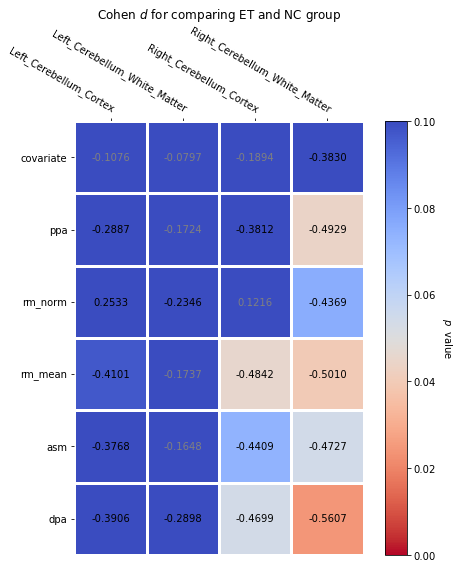

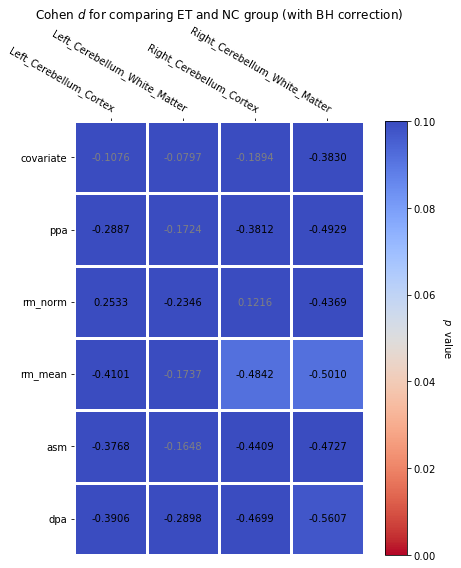

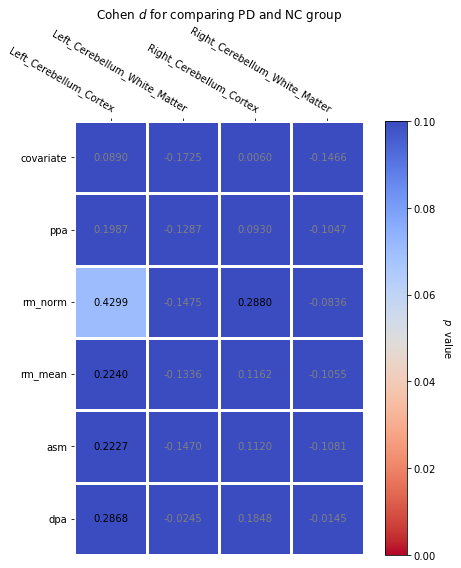

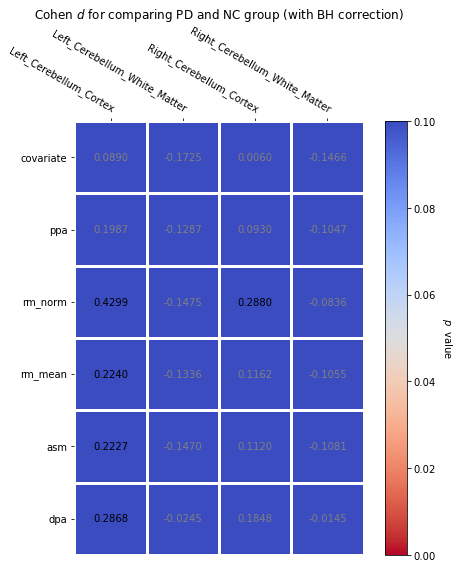

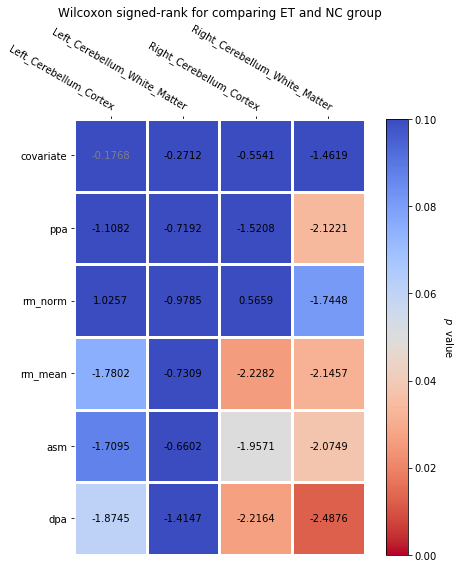

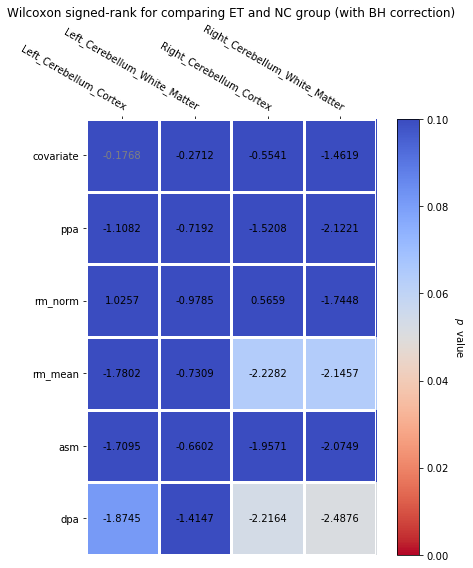

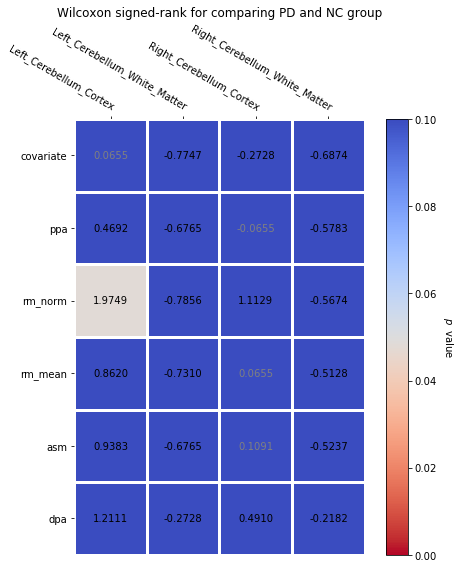

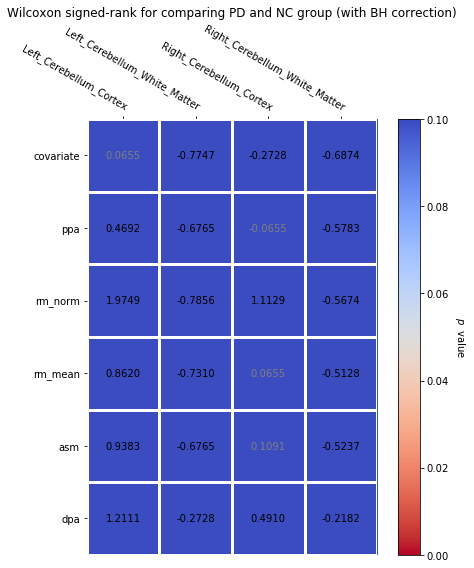

In [11]:
def reformat_df(df, group_name, es_name):
    import statsmodels.stats as sts
    method_name=df['method'].unique();
    voi_name=df[df.method=='covariate']['voi'].unique();
    es_list=[]; p_list=[]; p_multi_list=[];
    for x in method_name:
        es_list_= list(df[(df['group']==group_name)&(df['method']==x)][es_name[0]]);
        p_list_ = list(df[(df['group']==group_name)&(df['method']==x)][es_name[1]]);
        p_multi_list_=sts.multitest.multipletests(p_list_, alpha=alpha/100,
                                                  method='fdr_bh', is_sorted=False, returnsorted=False)[1];
        es_list.append(es_list_); p_list.append(p_list_); p_multi_list.append(p_multi_list_);
    return es_list, p_list, p_multi_list, voi_name, method_name

##
sts_df = pd.DataFrame();
sts_df = sts_df.append(covariate_df.append(ppa_df.append(rm_norm_df.append(rm_mean_df.append(asm_df.append(dpa_df, ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True)

et_es, et_p, p_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['cohen_d', 'cohen_p']);
pd_es, pd_p, p_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['cohen_d', 'cohen_p']);

et_wil, et_wp, wp_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['Wilcoxon', 'Wilcoxon_p']);
pd_wil, pd_wp, wp_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['Wilcoxon', 'Wilcoxon_p']);

#method_name = ['Voi','DPA','PPA','RM-Norm', 'RM-Mean','Allometric Scaling']

import numpy as np
import matplotlib.pyplot as plt
def plot_effectsize(et_es, et_p, p_multi_et, NAME):
    #et_es=et_es[0]; et_p=et_p[0]; p_multi_et=p_multi_et[0];
    import matplotlib.pyplot as plt
    VMIN = 0; VMAX=0.1; C_MAP='coolwarm_r'; es_th = 0.2; f_size=[7,8];
    fig1=plt.figure(figsize=f_size); ax1 = fig1.subplots();
    im1, cbar1 = heatmap(np.array(et_p), method_name, voi_name, ax=ax1, cmap=C_MAP, cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    texts = annotate_heatmap(im1, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax1.set_title(NAME); fig1.tight_layout(); plt.show()
    fig2=plt.figure(figsize=f_size); ax2 = fig2.subplots();
    im2, cbar2 = heatmap(np.array(p_multi_et), method_name, voi_name, ax=ax2, cmap=C_MAP,cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    texts = annotate_heatmap(im2, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax2.set_title(NAME+' (with BH correction)'); fig2.tight_layout(); plt.show()
    return ax1, ax2

ax1_et_coh, ax2_et_coh = plot_effectsize(et_es, et_p, p_multi_et, 'Cohen $d$ for comparing ET and NC group')
ax1_pd_coh, ax2_pd_coh = plot_effectsize(pd_es, pd_p, p_multi_pd, 'Cohen $d$ for comparing PD and NC group')
ax1_et_wil, ax2_et_wil = plot_effectsize(et_wil, et_wp, wp_multi_et, 'Wilcoxon signed-rank for comparing ET and NC group')
ax1_pd_wil, ax2_pd_wil = plot_effectsize(pd_wil, pd_wp, wp_multi_pd, 'Wilcoxon signed-rank for comparing PD and NC group')


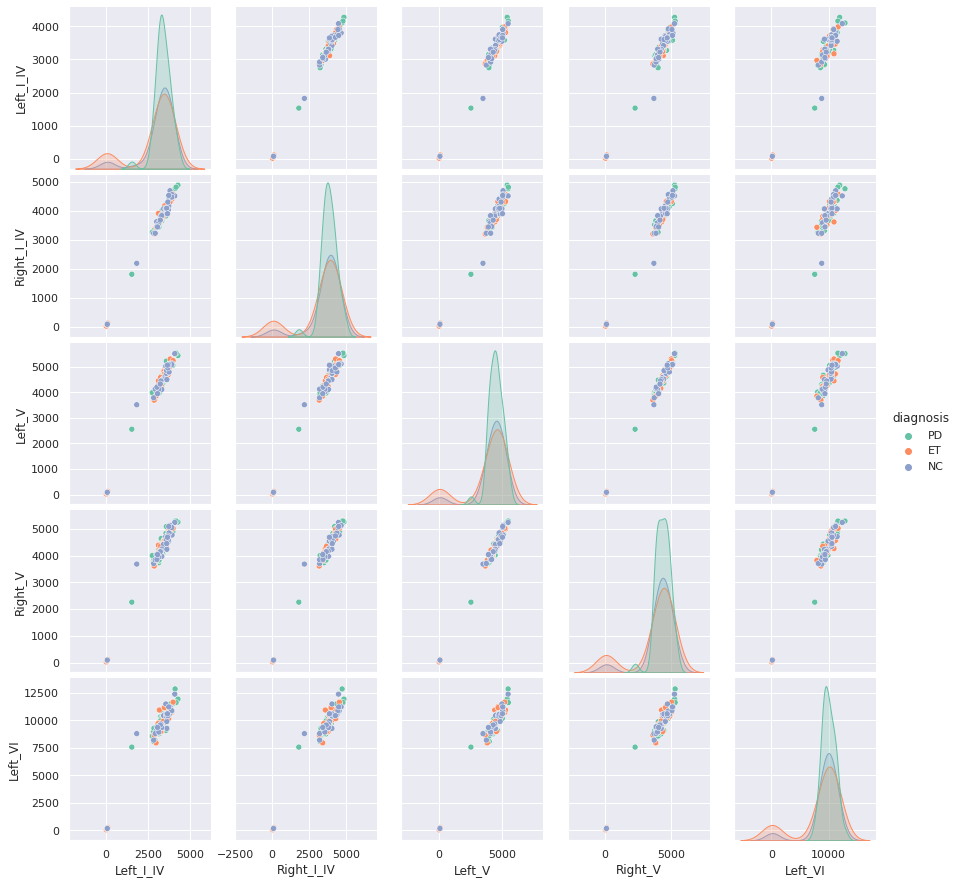

In [18]:
import seaborn as sns
mdtb_labels = ['MDTB_'+str(x+1) for x in range(10)];
suit_labels = ['Left_I_IV', 'Right_I_IV', 'Left_V', 'Right_V', 'Left_VI', 'Vermis_VI',
               'Right_VI', 'Left_CrusI', 'Vermis_CrusI', 'Right_CrusI', 'Left_CrusII',
               'Vermis_CrusII', 'Right_CrusII', 'Left_VIIb', 'Vermis_VIIb',
               'Right_VIIb', 'Left_VIIIa', 'Vermis_VIIIa', 'Right_VIIIa', 'Left_VIIIb',
               'Vermis_VIIIb', 'Right_VIIIb', 'Left_IX', 'Vermis_IX', 'Right_IX',
               'Left_X', 'Vermis_X', 'Right_X', 'Left_Dentate', 'Right_Dentate',
               'Left_Interposed', 'Right_Interposed', 'Left_Fastigial','Right_Fastigial'];
t1=sns.pairplot(curr_data, vars=suit_labels[:5],  hue="diagnosis", palette="Set2",
                diag_kind="kde", height=2.5)

In [26]:
[print(x,curr_data.loc[x,'Left_I_IV']) for x in curr_data.index if curr_data.loc[x,'Left_I_IV']<2000]

sub_0004 1532
sub_1450 43
sub_1500 68
sub_1920 59
sub_2400 22
sub_3700 116
sub_3900 63
sub_0041 1823
sub_0102 82
sub_0108 79


[None, None, None, None, None, None, None, None, None, None]

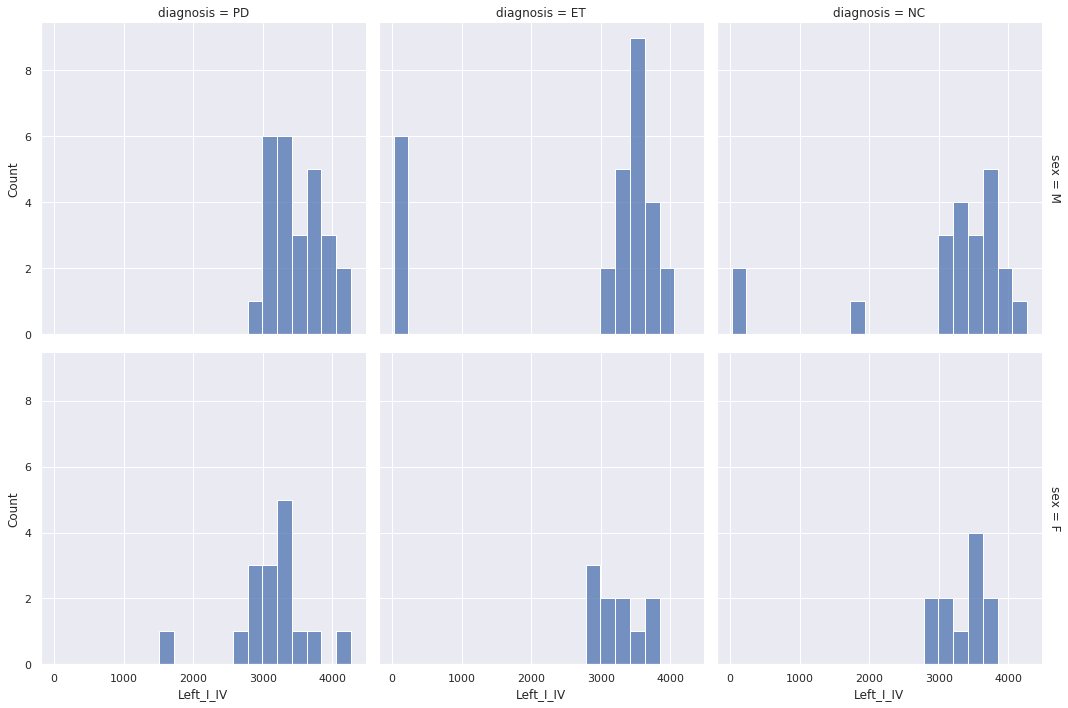

In [23]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.displot(
    curr_data, x="Left_I_IV", col="diagnosis", row="sex", facet_kws=dict(margin_titles=True))

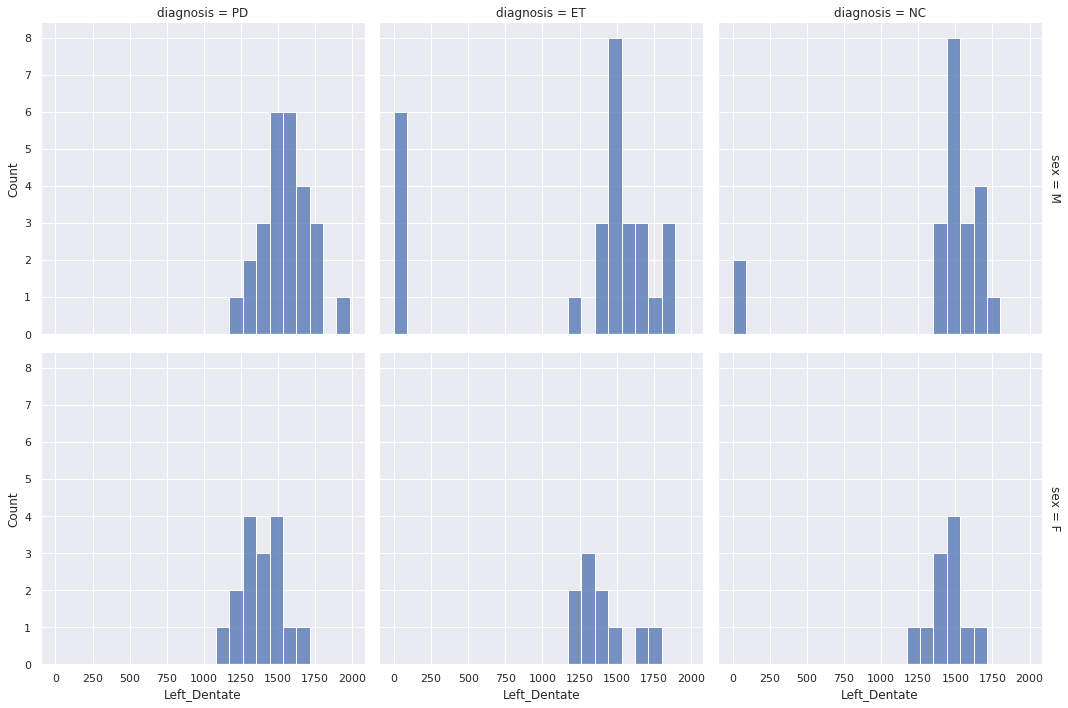

In [24]:
sns.displot(
    curr_data, x="Left_Dentate", col="diagnosis", row="sex", facet_kws=dict(margin_titles=True))

In [ ]:
import statsmodels.stats as sts
sts.multitest.multipletests(sts_df[sts_df['group']=='ETNC']['Wilcoxon_p'], alpha=0.05,
                            method='fdr_bh', is_sorted=False, returnsorted=False)
sts_df['method'].unique()

In [ ]:
import seaborn as sns
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_r', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_pcp', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_rm_norm', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex', hue="diagnosis")

In [ ]:
#distribution
g = sns.JointGrid(data=tab_data, x="Cerebellum_Cortex", y="Cerebellum_White_Matter", space=0, ratio=17)
g.plot_joint(sns.scatterplot,
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g",alpha=.6)
                 